In [2]:
import os
os.chdir("../../")

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
import catboost as cb
from scr.util import *

In [11]:
df = pd.read_csv('data/feature_engineered/null_del_xxx/train_null_del.csv')
df_submit = pd.read_csv('data/feature_engineered/null_del_xxx/test_null_median.csv')

### 欠損値を扱う場合

In [56]:
df_submit_null = pd.read_csv('data/test.csv')

age_null_id = df_submit_null.loc[df_submit_null['Age'].isna(), 'id'].values
duration_null_id = df_submit_null.loc[df_submit_null['DurationOfPitch'].isna(), 'id'].values
trips_null_id = df_submit_null.loc[df_submit_null['NumberOfTrips'].isna(), 'id'].values
income_null_id = df_submit_null.loc[df_submit_null['MonthlyIncome'].isna(), 'id'].values

for id in age_null_id:
    df_submit.loc[df_submit['id'] == id, 'Age'] = np.nan

for id in duration_null_id:
    df_submit.loc[df_submit['id'] == id, 'DurationOfPitch'] = np.nan

for id in trips_null_id:
    df_submit.loc[df_submit['id'] == id, 'NumberOfTrips'] = np.nan

for id in income_null_id:
    df_submit.loc[df_submit['id'] == id, 'MonthlyIncome'] = np.nan

# Catboost

In [13]:
# 特徴量選択
feature = [
    'Age',
    'TypeofContact',
    'CityTier',
    'DurationOfPitch',
    'Occupation',
    'Gender',
    'NumberOfPersonVisiting',
    'NumberOfFollowups',
    'ProductPitched',
    'PreferredPropertyStar',
    'NumberOfTrips',
    'Passport',
    'PitchSatisfactionScore',
    'Designation',
    'MonthlyIncome',
    'Marry',
    'Car',
    'Child',
    # 以下、作成特徴量
    #'AgeGroup',
    #'TypeofContactNULL',
    #'Motivation',
    #'EconomicPower',
    #'Child01',
    #'TripEasier',
    #'SalesPerformance',
    #'LivingCost',
    #'EconomicStability',
    #'TravelCost',
    #'NumberOfTrips_log',
    #'EconomicSegment',
    #'PackageMatch'
]

# catboostでカテゴリ変数を指定するためのリスト
category_columns = ['TypeofContact', 'CityTier', 'Occupation', 'Gender', 'NumberOfPersonVisiting', 'NumberOfFollowups', 'ProductPitched', 
                'PreferredPropertyStar', 'Passport', 'PitchSatisfactionScore', 'Designation', 'Marry', 'Car', 'Child'] + ['EconomicSegment']


df = mapping_columns_if_exist(df)
df_submit = mapping_columns_if_exist(df_submit)

X = df[feature]
y = df['ProdTaken']
df_submit = df_submit[feature]

In [14]:
display(X.iloc[:5, 20:])
display(df_submit.iloc[:5, 20:])

""
0
1
2
3
4


""
0
1
2
3
4


In [15]:
# 学習モデル Regressor

n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
cv_list = list(skf.split(X, y))

def train_catboost(X, y, cv, params: dict = None):
    if params is None:
        params = {}

    models = []
    n_records = len(X)
    oof_pred = np.zeros((n_records, ))
    for i, (tr_idx, va_idx) in enumerate(cv):
        tr_x, va_x = X.iloc[tr_idx], X.iloc[va_idx]
        tr_y, va_y = y.iloc[tr_idx], y.iloc[va_idx]
        model = cb.CatBoostRegressor(**params)
        model.fit(tr_x, tr_y, eval_set=(va_x, va_y), use_best_model=True, verbose=100)
        oof_pred[va_idx] = model.predict(va_x)
        models.append(model)
    return oof_pred, models

params = {
    'loss_function': 'RMSE',
    'eval_metric': 'AUC',
    'iterations': 10000,
    'learning_rate': 0.005,
    'depth': 5,
    # 'cat_features': category_columns,
    'l2_leaf_reg': 4,  # 3 ~ 10
    'verbose': 200,
    'random_seed': 42,
}

oof, models = train_catboost(X, y, cv_list, params)

0:	test: 0.7824174	best: 0.7824174 (0)	total: 3.83ms	remaining: 38.3s
100:	test: 0.8194544	best: 0.8212366 (11)	total: 167ms	remaining: 16.4s
200:	test: 0.8255078	best: 0.8255078 (200)	total: 285ms	remaining: 13.9s
300:	test: 0.8277180	best: 0.8278176 (293)	total: 398ms	remaining: 12.8s
400:	test: 0.8319793	best: 0.8319793 (400)	total: 538ms	remaining: 12.9s
500:	test: 0.8333333	best: 0.8333333 (476)	total: 660ms	remaining: 12.5s
600:	test: 0.8339108	best: 0.8339705 (544)	total: 797ms	remaining: 12.5s
700:	test: 0.8339705	best: 0.8344683 (667)	total: 923ms	remaining: 12.2s
800:	test: 0.8357626	best: 0.8358224 (795)	total: 1.04s	remaining: 12s
900:	test: 0.8365990	best: 0.8366189 (897)	total: 1.16s	remaining: 11.8s
1000:	test: 0.8378734	best: 0.8379729 (986)	total: 1.28s	remaining: 11.5s
1100:	test: 0.8384110	best: 0.8384906 (1073)	total: 1.39s	remaining: 11.2s
1200:	test: 0.8385703	best: 0.8389287 (1176)	total: 1.5s	remaining: 11s
1300:	test: 0.8393668	best: 0.8395460 (1286)	total: 1.6

In [16]:
# モデルを保存
# ベストモデルを保存中
# 学習データセットについて、意味がある欠損値2つ以外を削除した学習データセット。

# for i, model in enumerate(models):
#     with open ('model/catboost/catboost_model_{}.pkl'.format(i), 'wb') as f:
#         pickle.dump(model, f)

    feature_importance           column  fold
0            11.148802              Age     1
1             2.419099    TypeofContact     1
2             5.727438         CityTier     1
3             4.852312  DurationOfPitch     1
4             3.635383       Occupation     1
..                 ...              ...   ...
85            9.723485      Designation     5
86           15.457745    MonthlyIncome     5
87            6.627523            Marry     5
88            1.406999              Car     5
89            2.229451            Child     5

[90 rows x 3 columns]


C:\Users\ricke\AppData\Local\Temp\ipykernel_12404\4245149276.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=feature_importance_df,


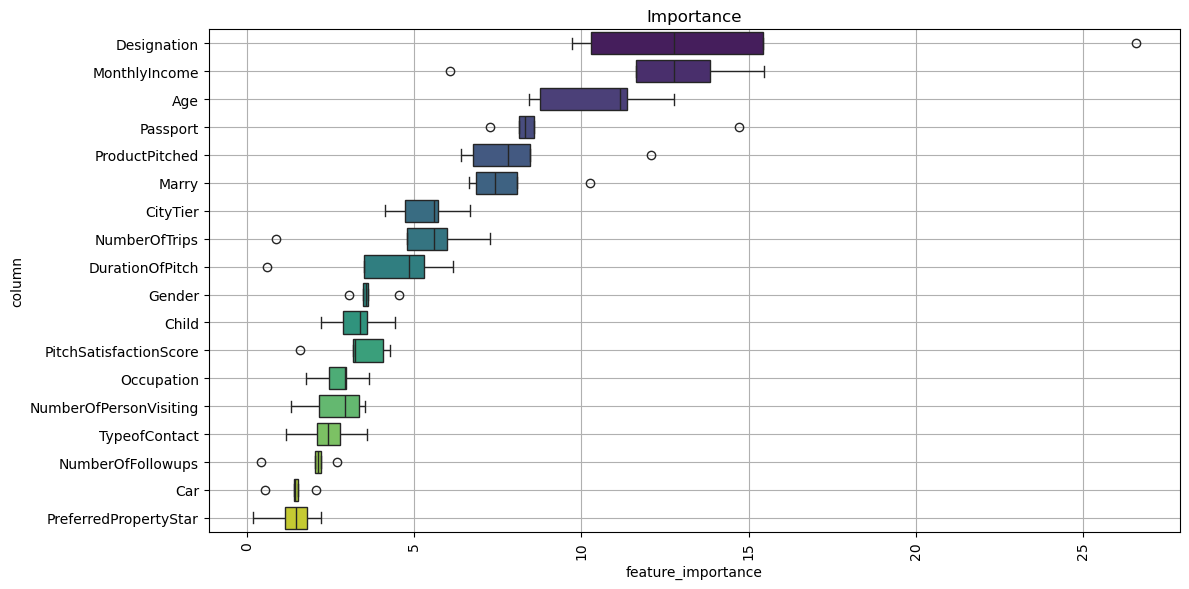

In [17]:
# 特徴量の重要度

def visualize_importance(models, feat_train_df):
    feature_importance_df = pd.DataFrame()
    for i, model in enumerate(models):
        _df = pd.DataFrame()
        _df["feature_importance"] = model.feature_importances_
        _df["column"] = feat_train_df.columns
        _df["fold"] = i + 1
        feature_importance_df = pd.concat([feature_importance_df, _df],
                                        axis=0, ignore_index=True)

    order = feature_importance_df.groupby("column")\
        .sum()[["feature_importance"]]\
        .sort_values("feature_importance", ascending=False).index

    fig, ax = plt.subplots(figsize=(12, max(6, len(order) * .25)))
    print(feature_importance_df)
    #feature_importance_df_drop_speed = feature_importance_df[feature_importance_df["column"] != "speed"]
    sns.boxplot(data=feature_importance_df,
                x="feature_importance",
                y="column",
                order=order,
                ax=ax,
                palette="viridis",
                orient="h")
    ax.tick_params(axis="x", rotation=90)
    ax.set_title("Importance")
    ax.grid()
    fig.tight_layout()
    return fig, ax, feature_importance_df

fig, ax, feature_importance_df = visualize_importance(models, X)

# Classifier

In [16]:
# 学習モデル Classifier

n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
cv_list = list(skf.split(X, y))

def train_catboost(X, y, cv, params: dict = None):
    if params is None:
        params = {}

    models = []
    n_records = len(X)
    oof_pred = np.zeros((n_records, ))
    for i, (tr_idx, va_idx) in enumerate(cv):
        tr_x, va_x = X.iloc[tr_idx], X.iloc[va_idx]
        tr_y, va_y = y.iloc[tr_idx], y.iloc[va_idx]
        model = cb.CatBoostClassifier(**params)
        model.fit(tr_x, tr_y, eval_set=(va_x, va_y), use_best_model=True, verbose=100)
        oof_pred[va_idx] = model.predict_proba(va_x)[:, 1]
        models.append(model)
    return oof_pred, models

params = {
    'scale_pos_weight': 497/2992,
    'loss_function': 'Logloss',
    'eval_metric': 'AUC',
    'iterations': 8000,
    'learning_rate': 0.005,
    'depth': 5,
    # 'cat_features': category_columns,
    'l2_leaf_reg': 7,    # 3 ~ 10
    'verbose': 200,
    'random_seed': 42,
}

oof, models = train_catboost(X, y, cv_list, params)

0:	test: 0.6006940	best: 0.6006940 (0)	total: 3.64ms	remaining: 29.1s
100:	test: 0.8277926	best: 0.8299164 (88)	total: 236ms	remaining: 18.5s
200:	test: 0.8370234	best: 0.8370234 (200)	total: 452ms	remaining: 17.5s
300:	test: 0.8413545	best: 0.8414214 (299)	total: 668ms	remaining: 17.1s
400:	test: 0.8416221	best: 0.8427592 (342)	total: 883ms	remaining: 16.7s
500:	test: 0.8424582	best: 0.8427926 (438)	total: 1.1s	remaining: 16.5s
600:	test: 0.8411037	best: 0.8427926 (438)	total: 1.32s	remaining: 16.3s
700:	test: 0.8399164	best: 0.8427926 (438)	total: 1.54s	remaining: 16s
800:	test: 0.8397157	best: 0.8427926 (438)	total: 1.75s	remaining: 15.7s
900:	test: 0.8399666	best: 0.8427926 (438)	total: 1.96s	remaining: 15.4s
1000:	test: 0.8402007	best: 0.8427926 (438)	total: 2.17s	remaining: 15.1s
1100:	test: 0.8403010	best: 0.8427926 (438)	total: 2.38s	remaining: 14.9s
1200:	test: 0.8403177	best: 0.8427926 (438)	total: 2.59s	remaining: 14.6s
1300:	test: 0.8403344	best: 0.8427926 (438)	total: 2.81

# 提出

In [9]:
# for col in category_columns:
#     df_submit[col] = df_submit[col].astype('str')

y_submit = np.zeros(len(df_submit))
for model in models:
    y_submit += model.predict(df_submit) / len(models)

index = pd.read_csv('data/test.csv')['id'].values
df_submit = pd.DataFrame({
    "id": index,
    "prediction": y_submit
})

df_submit['prediction'] = np.where(df_submit['prediction'] < 0, 0, df_submit['prediction'])
df_submit.head()

,id,prediction
0,3489,0.059302
1,3490,0.234530
2,3491,0.354996
3,3492,0.446496
4,3493,0.334198


In [10]:
path = 'submission/submit_20_cat_in_TripEasier_欠損値を中央値で補完した.csv'

In [11]:
df_submit.to_csv(path, index=False, header=None)